In [1]:

import glob
import pathlib
import pandas as pd
import seaborn as sns
# import tensorflow as tf
import os
import random

import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython import display
from IPython import display
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.autograd import Variable
import torch
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
import pickle
from torch import nn
import torch.optim as optim

import pickle

import os
import pandas as pd
from torch.utils.data import Dataset


In [2]:
#calc likelihood:
def calc_real_likelihood(inputs):
    SIGMA=1
    sum_arg=0
    wav_data2 = inputs.squeeze()

    for i in range(len(wav_data2)-1):
        if i==0:
            sum_arg += (wav_data2[0] - 0)**2
        else:
            sum_arg += (wav_data2[i] - 0.9*wav_data2[i-1])**2

    likelihood = sum_arg*(-0.5)*((1/SIGMA)**2) + len(wav_data2)*np.log(1/(np.sqrt(2*np.pi)*SIGMA))

    return likelihood

class NoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor[idx]
        return item, cur_gt


def create_ar_noise():
    AR_COEF_MIN = 0.9
    AR_COEF_MAX = 0.9
    order=1
    # AR_COEF = 0.9

    n_samples=8000
    mu=0
    sigma=1
    """Generate auto-regressive noise."""
    # Generate white noise
    white_noise = np.random.normal(mu, sigma, n_samples + order)

    # Initialize AR coefficients randomly
    # ar_coefs = np.random.uniform(-0.5, 0.5, order)
    ar_coefs = np.random.uniform(AR_COEF_MIN,AR_COEF_MAX, order)

    # Generate AR noise
    ar_noise = np.zeros_like(white_noise)
    for i in range(order, n_samples + order):
        ar_noise[i] = np.dot(ar_coefs, ar_noise[i - order:i]) + white_noise[i]
    ar_noise = ar_noise[order:]  # Discard initial transient
    return ar_noise

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
            
        )
        
def create_dataset(cur_noise_scaling):
    ar_noise = cur_noise_scaling*create_ar_noise()
    ar_noise2 = cur_noise_scaling*create_ar_noise()

    # Create datasets and data loaders
    train_tensor = torch.tensor(ar_noise, dtype=torch.float32).view(1,1,-1)
    test_tensor = torch.tensor(ar_noise2, dtype=torch.float32).view(1,1,-1)


    betas=get_named_beta_schedule("linear", 200)

    alphas = 1.0 - betas
    alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
    # white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
    g_t = -torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))

    train_full_tensors = train_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
        train_full_tensors[i,:,:] = train_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

    test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,test_tensor.shape)
        test_full_tensors[i,:,:] = test_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]
        

    #Create TensorDatasets
    train_dataset = NoiseDataset(train_full_tensors,g_t)
    test_dataset = NoiseDataset(test_full_tensors,g_t)

    #Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
    return train_dataset, test_dataset, ar_noise, ar_noise2


def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation +1
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class Network4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1d(1, 2, kernel_size=5, dilation=1)
        self.tanh = nn.ReLU()
        self.conv2 = CausalConv1d(2, 2, kernel_size=5, dilation=2)
        self.tanh2 = nn.ReLU()
        self.conv3 = CausalConv1d(2, 2, kernel_size=5, dilation=2)

    def forward(self, x, cur_gt):
        x = self.conv1(x)
        if self.conv1.padding[0] != 0:
            x = x[:, :, :-self.conv1.padding[0]-1]  
        x = self.tanh(x)
        x = self.conv2(x)
        if self.conv2.padding[0] != 0:
            x = x[:, :, :-self.conv2.padding[0]-1] 
        x = self.tanh2(x)
        x = self.conv3(x)
        if self.conv3.padding[0] != 0:
            x = x[:, :, :-self.conv3.padding[0]-1]  
        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood



class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1d(1, 2, kernel_size=3, dilation=1)

    def forward(self, x, cur_gt):
        x = self.conv1(x)
        # print("self.conv1.padding: ", self.conv1.padding)
        if self.conv1.padding[0] != 0:
            x = x[:, :, :-self.conv1.padding[0]-1]  # remove trailing padding
        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood


def calc_model_likelihood(tensor_, model, curgt):
    with torch.no_grad():
        output = (model(tensor_.to("cuda"), curgt.to("cuda", dtype=torch.float)))


    wav_tensor = tensor_.squeeze()
    means_=output[0].squeeze()
    stds_ = output[1].squeeze()

    exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
    param_all = 1/(np.sqrt(2*np.pi)*stds_)
    model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
    model_likelihood2 = torch.sum(exp_all, axis=-1) 
    model_likelihood = model_likelihood1 + model_likelihood2
    
    return model_likelihood

    
def train_nets(train_dataset, test_dataset,epochs=6000):
    nets = [Network() for i in range(200)]


    loss_array = {}
    loss_test_array = {}

    for i,model in tqdm(enumerate(nets)):
        model.to("cuda")
        model.train()

        optimizer = optim.Adam(model.parameters())
        for epoch in range(epochs):
            running_loss = 0.0
            # for batch_idx, (batch_tensor, gt_tensor) in enumerate(train_loader):
            batch_tensor, gt_tensor = train_dataset.__getitem__(i)
            # for data in train_loader:
            optimizer.zero_grad()
            batch_tensor = batch_tensor.view(1,1,-1).to("cuda", dtype=torch.float)
            gt_tensor = gt_tensor.to("cuda", dtype=torch.float)
            # print("batch_tensor.shape:",batch_tensor.shape)
            # print()
            means, stds = model(batch_tensor, gt_tensor)


            loss = model.casual_loss( means, stds, wav_tensor=batch_tensor)
            # print("loss",loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                
                
            if epochs%100==0:
                with torch.no_grad():
                    test_inputs, gt_test = test_dataset.__getitem__(i)
                    test_inputs = test_inputs.view(1,1,-1).to("cuda", dtype=torch.float)
                    gt_test = gt_test.to("cuda", dtype=torch.float)
                    meanst, stdst = model(test_inputs, gt_test)
                loss_t = model.casual_loss( meanst, stdst, wav_tensor=test_inputs)
                if i in loss_test_array:
                    loss_test_array[i].append(float(loss_t))
                else:
                    loss_test_array[i] = [float(loss_t)]
            
                # print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss}")  #/ len(train_loader
            # loss_array[i].append(float(loss))
            if i in loss_array:
                loss_array[i].append(float(loss))
            else:
                loss_array[i] = [float(loss)]
        # print("gt_tensor:", float(gt_tensor))
        nets[i].parameters = model.parameters
        print(f"Model {i} Epoch {epoch+1}/{epochs}, Loss: {running_loss}")
    return nets, loss_array, loss_test_array

In [3]:
# with open('/data/ephraim/datasets/known_noise/undiff/exp_ar_i_real/5f_snrs.pickle', 'rb') as handle:
#     snr_df = pickle.load(handle)
# root = "/data/ephraim/datasets/known_noise/undiff/exp_ar_i_real/"
# snr_df

In [4]:
import torchaudio
# failed = {}
# i=snr_df[snr_df["dir"]=="b"].index[1]
# train_idx = i+1

# noise_idx = snr_df["noise_idx"][train_idx]
# cur_dir = Path(root +snr_df["dir"][train_idx])
# cur_snr = snr_df["snr"][train_idx]
# cur_noise_scaling = snr_df["noise_scaling"][train_idx]
# noise_index = snr_df["noise_idx"][train_idx]
# print(cur_snr,cur_dir, noise_index, cur_noise_scaling)
# pickle_path = cur_dir/("snr"+str(int(cur_snr))+"_"+str(noise_index)+"_models.pickle")

# noise_path = snr_df["noise_path"][train_idx]
# speech_path = snr_df["clean_wav"][train_idx]
# noisy_path = snr_df["noisy_wav"][train_idx]
# noise_whole, sr = torchaudio.load(noise_path)
# print(noise_whole.shape)
# sr
    

In [5]:
def create_dataset_real(noise_whole, sr):
    noise_sample1 = noise_whole[:, 0:int(sr/2)]
    noise_sample2 = noise_whole[:, int(sr/2):sr]

    # Create datasets and data loaders
    train_tensor = torch.tensor(noise_sample1, dtype=torch.float32).view(1,1,-1)
    test_tensor = torch.tensor(noise_sample2, dtype=torch.float32).view(1,1,-1)


    betas=get_named_beta_schedule("linear", 200)

    alphas = 1.0 - betas
    alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
    # white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
    g_t = -torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))

    train_full_tensors = train_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
        train_full_tensors[i,:,:] = train_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

    test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,test_tensor.shape)
        test_full_tensors[i,:,:] = test_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]
        

    #Create TensorDatasets
    train_dataset = NoiseDataset(train_full_tensors,g_t)
    test_dataset = NoiseDataset(test_full_tensors,g_t)

    #Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
    return train_dataset, test_dataset, noise_sample1, noise_sample2

In [6]:
import torch.multiprocessing as mp

def train_nets_process(train_dataset, test_dataset, device, idxes, epochs=500):
    if idxes[0] == 50:
        quarter_idx=0
    elif idxes[0] == 50:
        quarter_idx=1
    elif idxes[0] == 100:
        quarter_idx=2
    elif idxes[0] == 150:
        quarter_idx=3
    else:
        print ("no identifiesd quarter")
        raise Exception
    
    nets = [Network4() for i in range(len(idxes))]

    
    loss_array = {}
    loss_test_array = {}

    net_counter=-1
    for i in idxes:
        net_counter+=1
        model = nets[net_counter]
        model.to(device)
        model.train()

        optimizer = optim.Adam(model.parameters())
        for epoch in range(epochs):
            running_loss = 0.0
            # for batch_idx, (batch_tensor, gt_tensor) in enumerate(train_loader):
            batch_tensor, gt_tensor = train_dataset.__getitem__(i)
            # for data in train_loader:
            optimizer.zero_grad()
            batch_tensor = batch_tensor.view(1,1,-1).to("cuda", dtype=torch.float)
            gt_tensor = gt_tensor.to("cuda", dtype=torch.float)
            # print("batch_tensor.shape:",batch_tensor.shape)
            # print()
            means, stds = model(batch_tensor, gt_tensor)


            loss = model.casual_loss( means, stds, wav_tensor=batch_tensor)
            # print("loss",loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                
                
            if epochs%100==0:
                with torch.no_grad():
                    test_inputs, gt_test = test_dataset.__getitem__(i)
                    test_inputs = test_inputs.view(1,1,-1).to("cuda", dtype=torch.float)
                    gt_test = gt_test.to("cuda", dtype=torch.float)
                    meanst, stdst = model(test_inputs, gt_test)
                loss_t = model.casual_loss( meanst, stdst, wav_tensor=test_inputs)
                if i in loss_test_array:
                    loss_test_array[i].append(float(loss_t))
                else:
                    loss_test_array[i] = [float(loss_t)]
            
                # print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss}")  #/ len(train_loader
            # loss_array[i].append(float(loss))
            if i in loss_array:
                loss_array[i].append(float(loss))
            else:
                loss_array[i] = [float(loss)]
        # print("gt_tensor:", float(gt_tensor))
        nets[i].parameters = model.parameters
        print(f"Model {i} Epoch {epoch+1}/{epochs}, Loss: {running_loss}")
    
    return nets, loss_array, loss_test_array, quarter_idx


def train_nets_parralel(train_dataset, test_dataset,epochs=6000,num_nets=200):
    results = []
    idxes_all = [list(range(0,50)),list(range(50,100)),list(range(100,150)),list(range(150,200))]
    devices = [f'cuda:{i}' for i in range(4)]
    with mp.get_context('spawn').Pool(processes=4) as pool:
        args = [(train_dataset, test_dataset,devices[i % 4], idxes) for i, idxes in enumerate(idxes_all)]
        results = pool.starmap(train_nets_process, args)

    return results



In [7]:
# train_dataset, test_dataset, noise_sample1, noise_sample2 = create_dataset_real(noise_whole, sr)
        
# # nets, loss_array, loss_test_array = train_nets(train_dataset, test_dataset)
# result = train_nets_parralel(train_dataset, test_dataset,epochs=6000,num_nets=200)


In [8]:
################################
#load
####################################

In [12]:
import pickle
with open('/data/ephraim/datasets/known_noise/undiff/exp_ar_g_high/b/snr5_models.pickle', 'rb') as handle:
    params_dict = pickle.load(handle)

Text(0.5, 1.0, 'loss_test_array')

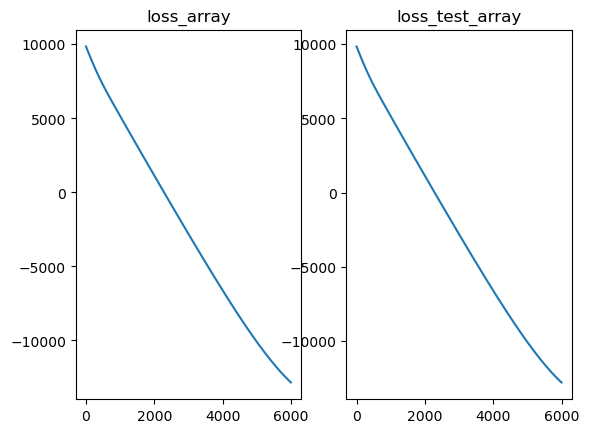

In [14]:
j=2
# g_t[j]
model = params_dict["nets"][j]
loss_array = params_dict["loss_array"][j]
loss_test_array = params_dict["loss_test_array"][j]
ar_noise = params_dict["ar_noise"]
train_dataset = params_dict["train_dataset"]
test_dataset = params_dict["test_dataset"]
ar_coefs = params_dict["ar_coefs"]
#  "train_dataset": train_dataset, "test_dataset": test_dataset,"ar_coefs":ar_coefs, "loss_array":loss_array, "loss_test_array": loss_test_array, "ar_noise": ar_noise
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].plot(loss_array)
axs[0].set_title('loss_array')
axs[1].plot(loss_test_array)
axs[1].set_title('loss_test_array')

In [16]:
def create_ar_noise(n_samples=8000):
    AR_COEF_MIN = -0.9
    AR_COEF_MAX = -0.9
    order=1

    # AR_COEF = 0.9

    
    mu=0
    sigma=1
    """Generate auto-regressive noise."""
    # Generate white noise
    white_noise = np.random.normal(mu, sigma, n_samples + order)

    # Initialize AR coefficients randomly
    # ar_coefs = np.random.uniform(-0.5, 0.5, order)
    ar_coefs = np.random.uniform(AR_COEF_MIN,AR_COEF_MAX, order)

    # Generate AR noise
    ar_noise = np.zeros_like(white_noise)
    for i in range(order, n_samples + order):
        ar_noise[i] = np.dot(ar_coefs, ar_noise[i - order:i]) + white_noise[i]
    ar_noise = ar_noise[order:]  # Discard initial transient
    return torch.from_numpy(ar_noise).view(1,-1)

ar_noise = create_ar_noise(n_samples=8000)
ar_noise2 = create_ar_noise(n_samples=8000)
train_tensor = torch.tensor(ar_noise, dtype=torch.float32).view(1,1,-1)
test_tensor = torch.tensor(ar_noise2, dtype=torch.float32).view(1,1,-1)
betas=get_named_beta_schedule("linear", 200)

alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
# white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
g_t = -torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))

train_full_tensors = train_tensor.squeeze().repeat(200,1).view(200,1,-1)
for i in range(200):
    cur_white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
    train_full_tensors[i,:,:] = train_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
for i in range(200):
    cur_white_noise_diffusion = torch.normal(0,1,test_tensor.shape)
    test_full_tensors[i,:,:] = test_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]
    

#Create TensorDatasets
train_dataset = NoiseDataset(train_full_tensors,g_t)
test_dataset = NoiseDataset(test_full_tensors,g_t)


/tmp/ipykernel_2743909/753713745.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(ar_noise, dtype=torch.float32).view(1,1,-1)
/tmp/ipykernel_2743909/753713745.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(ar_noise2, dtype=torch.float32).view(1,1,-1)


In [17]:
model.to("cuda")
def calc_model_likelihood(model, tensor_, curgt):
    with torch.no_grad():
        output = (model(tensor_.to("cuda"), curgt.to("cuda", dtype=torch.float)))

    wav_tensor = tensor_.squeeze()
    means_=output[0].squeeze()
    stds_ = output[1].squeeze()

    exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
    param_all = 1/(np.sqrt(2*np.pi)*stds_)
    model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
    model_likelihood2 = torch.sum(exp_all, axis=-1) 

    model_likelihood = model_likelihood1 + model_likelihood2
    
    # model_likelihood = sum_
    return model_likelihood

    # curgt = g_t[i]
    
cur_train, curgt = train_dataset.__getitem__(j)
cur_train = cur_train.view(1,1,-1).to("cuda", dtype=torch.float)
    # gt_test = gt_test.to("cuda", dtype=torch.float)
    # meanst, stdst = model(test_inputs, gt_test)

lk = calc_model_likelihood(model.to("cuda"), cur_train, curgt)
print(curgt,lk)

tensor(-0.0245, dtype=torch.float64) tensor(-5593315.5000, device='cuda:0')


In [34]:
# test_inputs, gt_test = test_dataset.__getitem__(j)
# test_inputs = test_inputs.view(1,1,-1).to("cuda", dtype=torch.float)
# gt_test = gt_test.to("cuda", dtype=torch.float)
# meanst, stdst = model(test_inputs, gt_test)

tensor(-0.1024, device='cuda:0')


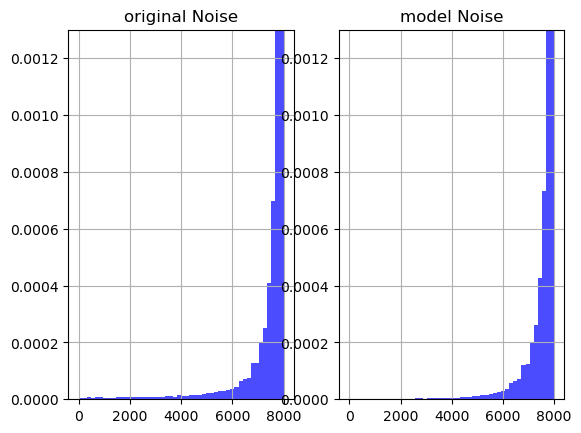

In [18]:

# j=0 #100
# model = nets[i].to("cuda")
# cur_test, curgt = test_dataset.__getitem__(j)
# cur_test = cur_test.view(1,1,-1).to("cuda", dtype=torch.float)
# curgt = curgt.to("cuda", dtype=torch.float)
# with torch.no_grad():
#         output_test_mean, output_test_std = (model(test_inputs, curgt))
# # audio_output = torch.normal(output_test_mean, output_test_std).squeeze().cpu().numpy()
cur_test, curgt = test_dataset.__getitem__(j)
test_inputs = cur_test.view(1,1,-1).to("cuda", dtype=torch.float)

with torch.no_grad():
    output_test_mean, output_test_std = (model(test_inputs.to("cuda"), curgt))
    print((output_test_std/output_test_mean).mean())
    
audio_output = torch.normal(output_test_mean, output_test_std).squeeze()

freqs1, magnitudes1 = signal.periodogram(cur_test[0,:].squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.periodogram(audio_output.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)

axis[1].set_ylim(0.0, limit)
plt.show()